In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import os

from pathlib import Path

In [5]:
def check_data_structure(base_dir='chest_xray'):
  print("Data structure check: ")
  print("="*60)
  base_path = Path(base_dir)
  if not base_path.exists():
    print(f"{base_path} does not exist")
    return False
  print(f"Base directory: {base_path} exists")
  print("="*60)
  required_dirs = {
      'train': ['NORMAL', 'PNEUMONIA'],
      'test': ['NORMAL', 'PNEUMONIA'],
  }

  all_ok = True
  for split, classes in required_dirs.items():
    split_path = base_path / split
    if not split_path.exists():
      print(f"{split_path} does not exist")
      all_ok = False
      continue
    for class_name in classes:
      class_path = split_path / class_name
      if not class_path.exists():
        print(f"{class_path} does not exist")
        all_ok = False
      else:
        image_files = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
        count = len(image_files)
        if count == 0:
          print(f"{class_path} is empty")
        else:
          print(f"{class_path} contains {count} images")
  return all_ok

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from typing import get_origin
IMG_SIZE = 224
IMG_CHANNELS = 3
BATCH_SIZE = 32
EPOCH = 20

GOOGLE_DRIVE_DATA_PATH = '/content/drive/MyDrive/chest_xray'
BASE_DIR = Path(GOOGLE_DRIVE_DATA_PATH)

DATA_DIR = BASE_DIR / 'chest_xray'
print(DATA_DIR)

TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
VAL_DIR = DATA_DIR / 'val'

print(TRAIN_DIR)
print(TEST_DIR)
print(VAL_DIR)
check_data_structure(GOOGLE_DRIVE_DATA_PATH)

/content/drive/MyDrive/chest_xray/chest_xray
/content/drive/MyDrive/chest_xray/chest_xray/train
/content/drive/MyDrive/chest_xray/chest_xray/test
/content/drive/MyDrive/chest_xray/chest_xray/val
Data structure check: 
Base directory: /content/drive/MyDrive/chest_xray exists
/content/drive/MyDrive/chest_xray/train/NORMAL contains 1341 images
/content/drive/MyDrive/chest_xray/train/PNEUMONIA contains 3875 images
/content/drive/MyDrive/chest_xray/test/NORMAL contains 234 images
/content/drive/MyDrive/chest_xray/test/PNEUMONIA contains 390 images


True

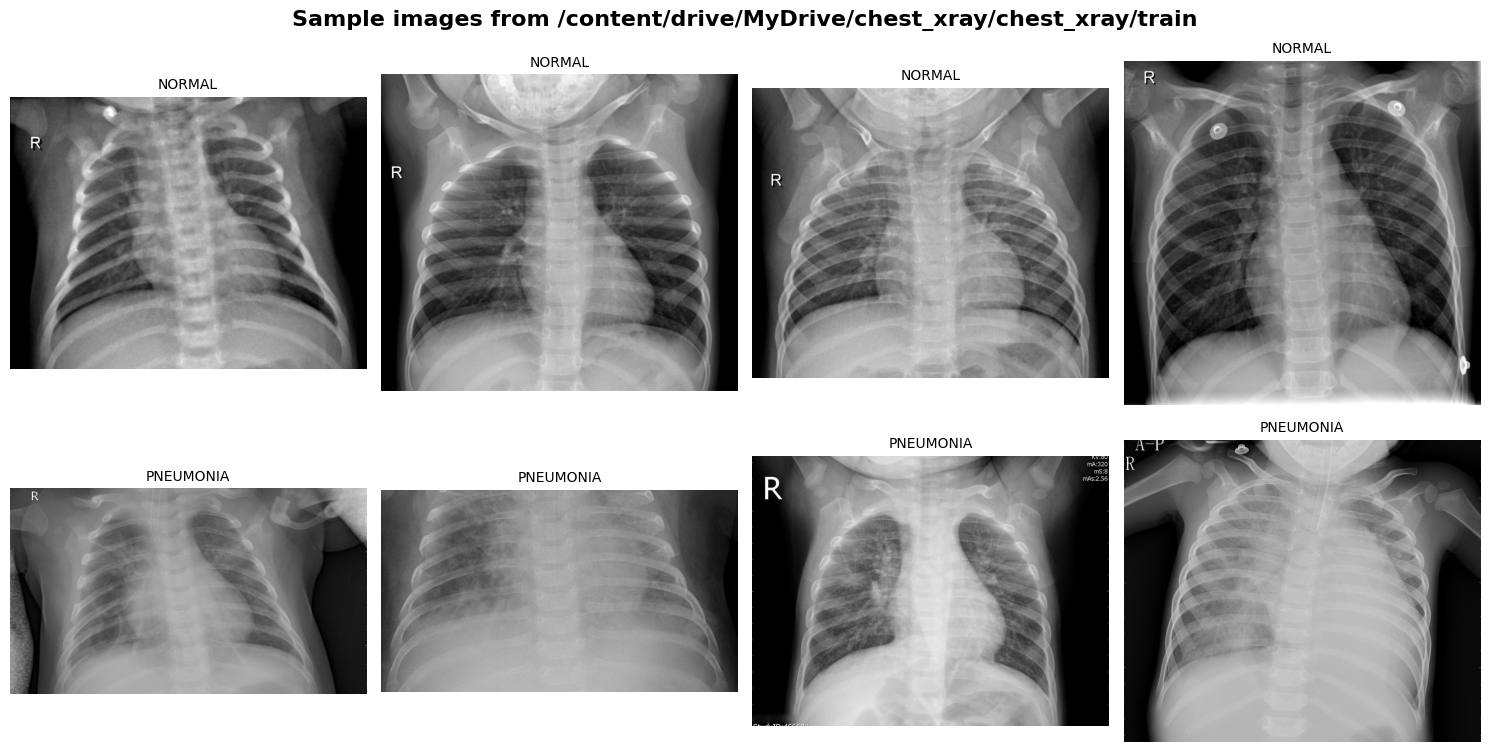

In [8]:
def visualize_samples(directory, num_samples = 4):
  if not os.path.exists(directory):
    print(f"Directory {directory} does not exist")
    return
  fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
  fig.suptitle(f"Sample images from {directory}", fontsize=16, fontweight='bold')
  classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
  for i, class_name in enumerate(classes):
    class_dir = os.path.join(directory, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    for j, sample_file in enumerate(sample_files):
      img_path = os.path.join(class_dir, sample_file)
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      axes[i, j].imshow(img, cmap='gray')
      axes[i, j].axis('off')
      axes[i, j].set_title(f"{class_name}", fontsize=10)
  plt.tight_layout()
  plt.show()

if os.path.exists(TRAIN_DIR):
  visualize_samples(TRAIN_DIR)


Data Augmentation - аугментация данных

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS)):
  model = Sequential([
      Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', padding='same'),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(0.25),

      Conv2D(128, (3, 3), activation='relu', padding='same'),
      BatchNormalization(),
      Conv2D(128, (3, 3), activation='relu', padding='same'),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(0.25),

      Conv2D(256, (3, 3), activation='relu', padding='same'),
      BatchNormalization(),
      Conv2D(256, (3, 3), activation='relu', padding='same'),
     MaxPooling2D(pool_size=(2,2)),
      Dropout(0.25),

      Flatten(),

      Dense(512, activation='relu'),
      BatchNormalization(),
      Dropout(0.5),

      Dense(256, activation='relu'),
      BatchNormalization(),
      Dropout(0.5),

      Dense(1, activation='sigmoid')
  ])
  return model

model = create_cnn_model()
print("Model create successfuly")
print("\nModel summary:")
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model create successfuly

Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 103,977,249 (396.64 MB)

 Trainable params: 103,974,881 (396.63 MB)

 Non-trainable params: 2,368 (9.25 KB)

None


In [11]:
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

In [12]:
os.makedirs('models', exist_ok=True)
callbacks = [
    EarlyStopping(patience=5, verbose=1, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(patience=3, verbose=1, monitor='val_loss', factor=0.5, min_lr=0.00001),
    ModelCheckpoint('models/best_pneumonia_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  ]

In [13]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb'
)

test_generator = train_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

val_generator = train_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb'
)



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [14]:
steps_per_epoch = train_generator.samples//BATCH_SIZE
validation_steps = None

if val_generator:
  validation_steps = val_generator.samples // BATCH_SIZE
else:
  validation_steps = test_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Model training start...")
print("="*50)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCH,
    validation_data=val_generator if val_generator else test_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose = 1
)
print("="*50)
print("Model training finished")


Steps per epoch: 163
Validation steps: 0
Model training start...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6836 - loss: 0.6940 - precision: 0.8538 - recall: 0.6905
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to models/best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 742s 4s/step - accuracy: 0.6840 - loss: 0.6932 - precision: 0.8540 - recall: 0.6911 - val_accuracy: 0.5000 - val_loss: 7.7272 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.8586 - loss: 0.3410 - precision: 0.9226 - recall: 0.8870
Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 155s 951ms/step - accuracy: 0.8587 - loss: 0.3408 - precision: 0.9226 - recall: 0.8871 - val_accuracy: 0.5000 - val_loss: 3.6242 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8989 - loss: 0.2584 - precision: 0.9333 - recall: 0.9315
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.8989 - loss: 0.2584 - precision: 0.9333 - recall: 0.9315 - val_accuracy: 0.5000 - val_loss: 1.6732 - val_precision: 0.5000 - val_recall: 1.0000 

163/163 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.9168 - loss: 0.1999 - precision: 0.9424 - recall: 0.9464 - val_accuracy: 0.6875 - val_loss: 0.6278 - val_precision: 0.8000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9190 - loss: 0.2082 - precision: 0.9491 - recall: 0.9430
Epoch 6: val_accuracy did not improve from 0.68750
163/163 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9191 - loss: 0.2081 - precision: 0.9491 - recall: 0.9430 - val_accuracy: 0.5625 - val_loss: 2.3189 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9292 - loss: 0.1819 - precision: 0.9496 - recall: 0.9548
Epoch 7: val_accuracy did not improve from 0.68750
163/163 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.9292 - loss: 0.1819 - precision: 0.9496 - recall: 0.9547 - val_accuracy: 0.6875 - val_loss: 1.2615 - val_precision: 0.6154 - val_recall: 1.0000 - lear

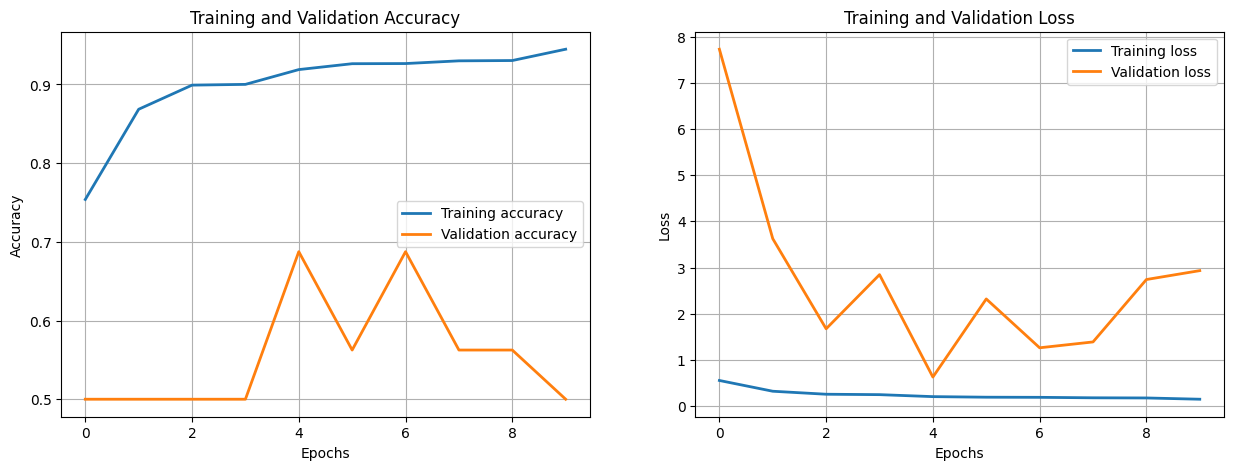

Final metrics on traning
Accuracy: 0.9448
Validation accuracy: 0.5000
Training loss: 0.1477
Validation loss: 2.9324


In [17]:
def plot_traning(history):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))
  axes[0].plot(history.history['accuracy'], label='Training accuracy', linewidth=2)
  axes[0].plot(history.history['val_accuracy'], label='Validation accuracy', linewidth=2)
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Accuracy')
  axes[0].set_title('Training and Validation Accuracy')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(history.history['loss'], label='Training loss', linewidth=2)
  axes[1].plot(history.history['val_loss'], label='Validation loss', linewidth=2)
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Loss')
  axes[1].set_title('Training and Validation Loss')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout
  plt.show()

  print("Final metrics on traning")
  print(f"Accuracy: {history.history['accuracy'][-1]:.4f}")
  print(f"Validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
  print(f"Training loss: {history.history['loss'][-1]:.4f}")
  print(f"Validation loss: {history.history['val_loss'][-1]:.4f}")
plot_traning(history)

In [20]:
print("model prediction")
test_generator.reset()

predictions = model.predict(test_generator, verbose=1)
predicted_classes = (predictions >= 0.5).astype(int).flatten()
class_names = list(test_generator.class_indices.keys())
true_classes = test_generator.classes

print(f"\nClasses: {class_names}")
print(f"  {class_names[0]} = 0")
print(f"  {class_names[1]} = 1")
print(f"Predicted classes: {predicted_classes}")


model prediction
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 729ms/step

Classes: ['NORMAL', 'PNEUMONIA']
  NORMAL = 0
  PNEUMONIA = 1
Predicted classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0
 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1

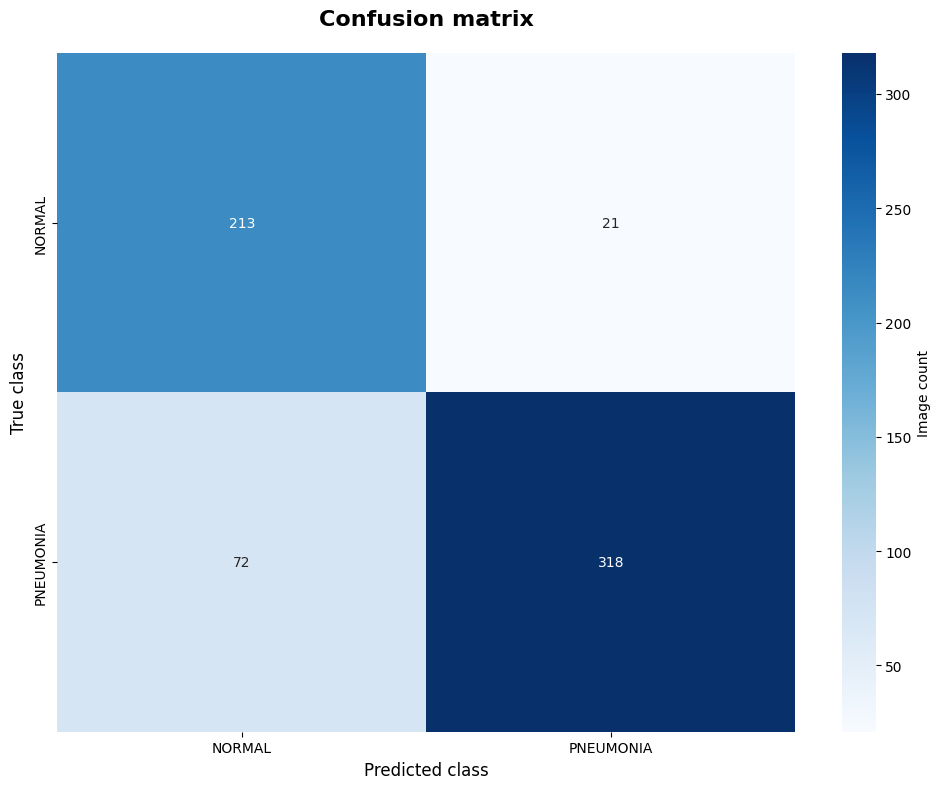


Confusion matrix:
          Predicted
              NORMAL           PNEUMONIA      
True  NORMAL    N                O              
     PNEUMONIA  P                N              

Metrics:
True Negative (TN): 213
False Negative (FN): 72
True Positive (TP): 318
False Positive (FP): 21


In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Image count'})
plt.xlabel('Predicted class', fontsize=12)
plt.ylabel('True class', fontsize=12)
plt.title('Confusion matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nConfusion matrix:")
print(f"          Predicted")
print(f"              {class_names[0]:<15}  {class_names[1]:<15}")
print(f"True  {class_names[0]:<8}  {class_names[0][0]:<15}  {class_names[0][1]:<15}")
print(f"     {class_names[1]:<8}  {class_names[1][0]:<15}  {class_names[1][1]:<15}")

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

print("\nMetrics:")
print(f"True Negative (TN): {TN}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP): {TP}")
print(f"False Positive (FP): {FP}")


In [27]:
from sklearn.metrics import classification_report, accuracy_score
print('Classification report')
print(classification_report(true_classes, predicted_classes, target_names=class_names, digits=4))

accuracy = accuracy_score(true_classes, predicted_classes)
precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0

f1_score_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
f1_score_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

print(f"\nAccuracy: {accuracy:.4f}({accuracy*100:.2f}%)")
print(f'\n  class {class_names[0]}')
print(f'    Precision: {precision_0:.4f})')
print(f'    Recall: {recall_0:.4f})')
print(f'    F1 score: {f1_score_0:.4f})')
print(f'\n  class {class_names[1]}')
print(f'    Precision: {precision_1:.4f})')
print(f'    Recall: {recall_1:.4f})')
print(f'    F1 score: {f1_score_1:.4f})')


Classification report
              precision    recall  f1-score   support

      NORMAL     0.7474    0.9103    0.8208       234
   PNEUMONIA     0.9381    0.8154    0.8724       390

    accuracy                         0.8510       624
   macro avg     0.8427    0.8628    0.8466       624
weighted avg     0.8665    0.8510    0.8531       624


Accuracy: 0.8510(85.10%)

  class NORMAL
    Precision: 0.7474)
    Recall: 0.9103)
    F1 score: 0.8208)

  class PNEUMONIA
    Precision: 0.9381)
    Recall: 0.8154)
    F1 score: 0.8724)


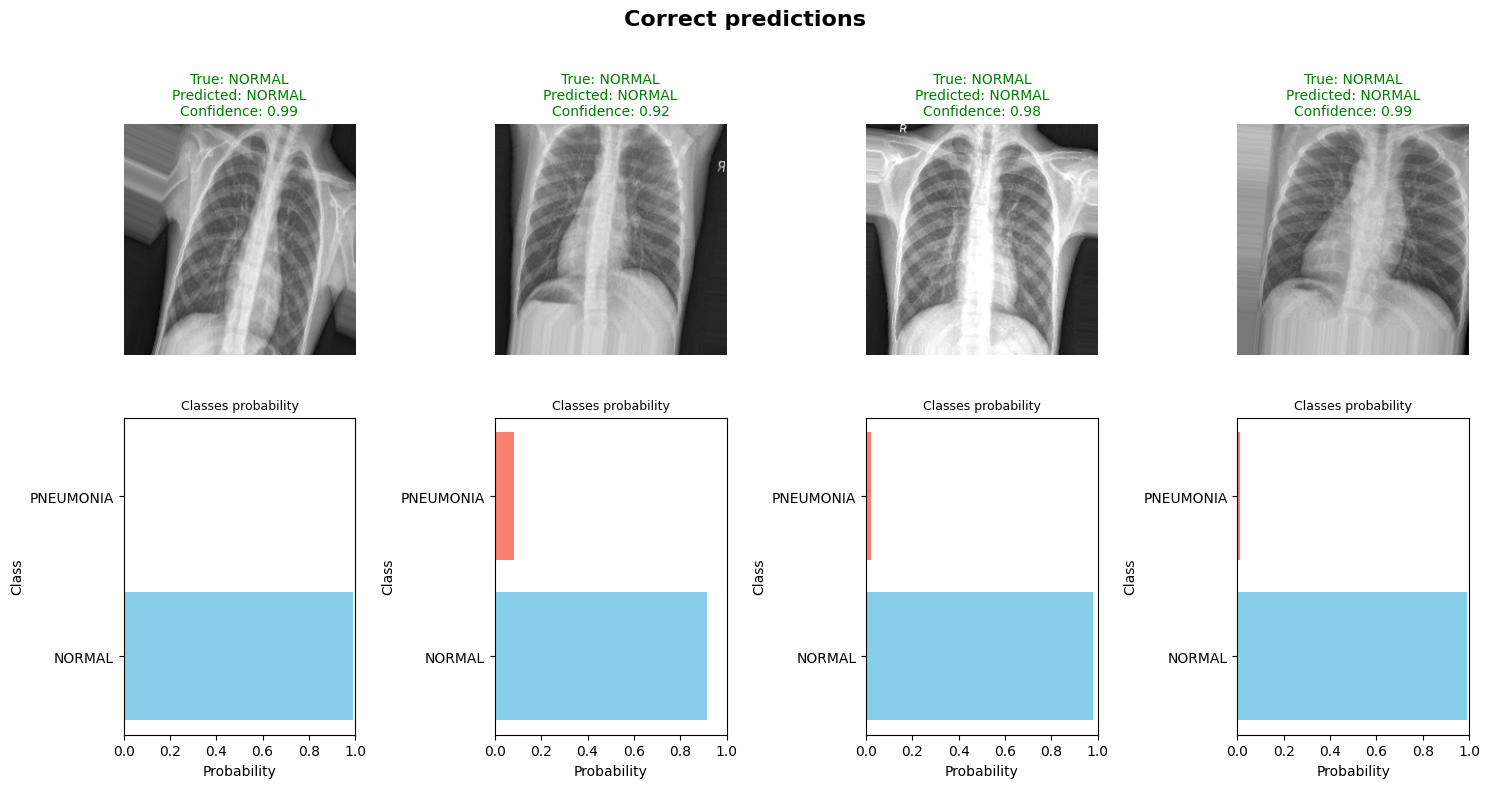

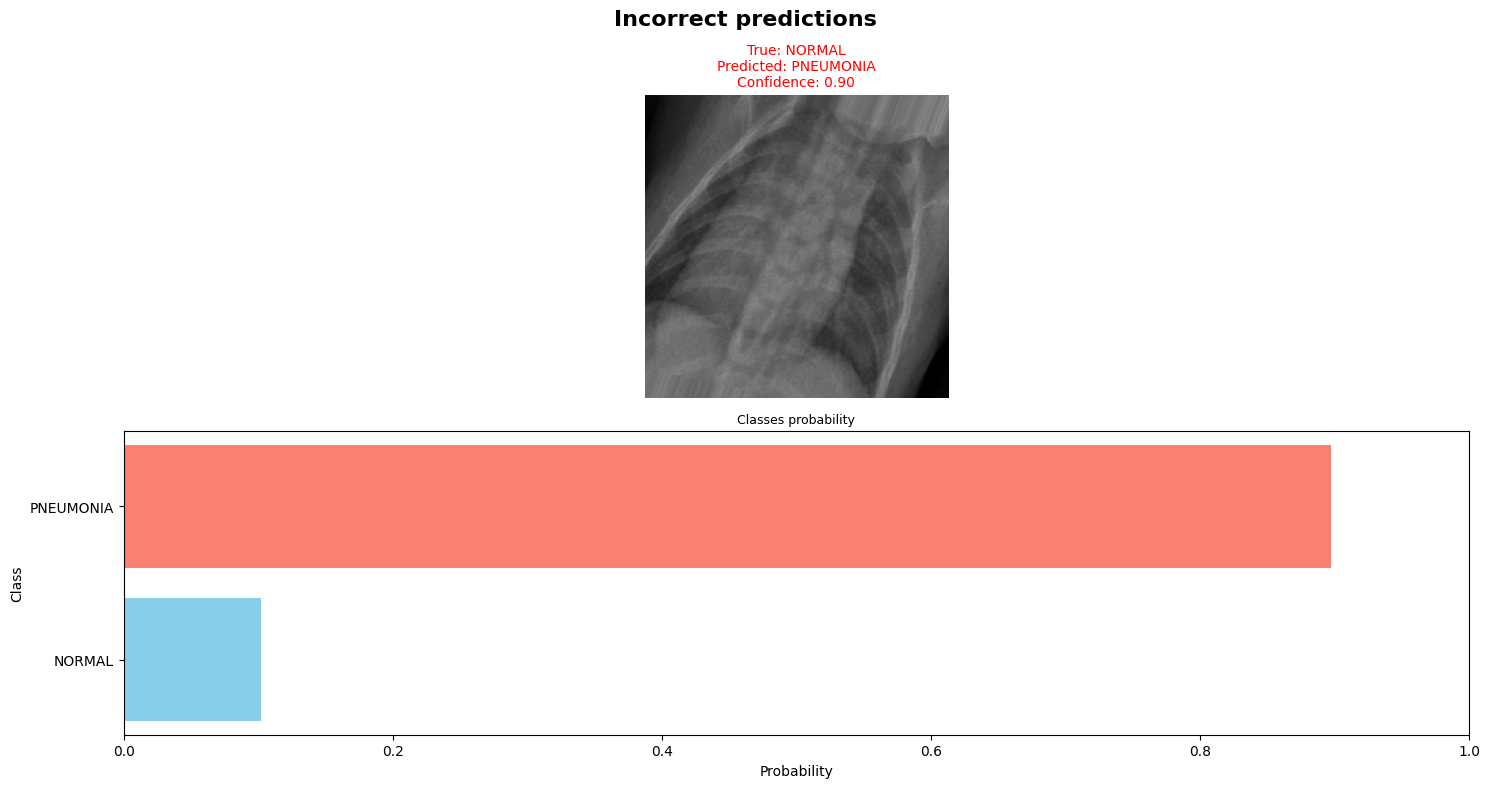

In [33]:
def visualize_predictions(test_generator, model, num_samples=8):
    test_generator.reset()
    x_batch, y_batch = next(test_generator)

    # Предсказания для одного batch
    predictions = model.predict(x_batch, verbose=0)  # shape: (batch_size, 1)
    predicted_classes = (predictions >= 0.5).astype(int).flatten()

    class_names = list(test_generator.class_indices.keys())
    class_names_reversed = {v: k for k, v in test_generator.class_indices.items()}

    correct_indices = []
    incorrect_indices = []

    for i in range(len(y_batch)):
        if predicted_classes[i] == y_batch[i]:
            correct_indices.append(i)
        else:
            incorrect_indices.append(i)

    # ---------- ПРАВИЛЬНЫЕ ПРЕДСКАЗАНИЯ ----------
    if correct_indices:
        num_correct = min(num_samples // 2, len(correct_indices))

        fig, axes = plt.subplots(2, num_correct, figsize=(15, 8))

        if num_correct == 1:
            axes = axes.reshape(2, 1)

        fig.suptitle("Correct predictions", fontsize=16, fontweight='bold')

        for i, img_idx in enumerate(correct_indices[:num_correct]):
            img = x_batch[img_idx]
            true_label = class_names_reversed[int(y_batch[img_idx])]
            predicted_label = class_names_reversed[int(predicted_classes[img_idx])]

            # model.predict -> P(class 1), пусть class_names[1] = 'PNEUMONIA'
            prob_pneumonia = float(predictions[img_idx][0])
            prob_normal = 1.0 - prob_pneumonia

            # Уверенность в предсказанном классе
            if predicted_classes[img_idx] == 1:
                confidence = prob_pneumonia
            else:
                confidence = prob_normal

            # Картинка
            axes[0, i].imshow(img)
            axes[0, i].axis('off')
            axes[0, i].set_title(
                f"True: {true_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}",
                fontsize=10,
                color='green'
            )

            # Бар-чарт с вероятностями
            axes[1, i].barh(
                [class_names[0], class_names[1]],
                [prob_normal, prob_pneumonia],
                color=['skyblue', 'salmon']
            )
            axes[1, i].set_title("Classes probability", fontsize=9)
            axes[1, i].set_xlim(0, 1)
            axes[1, i].set_xlabel('Probability')
            axes[1, i].set_ylabel('Class')

        plt.tight_layout()
        plt.show()

    # ---------- НЕПРАВИЛЬНЫЕ ПРЕДСКАЗАНИЯ ----------
    if incorrect_indices:
        num_incorrect = min(num_samples // 2, len(incorrect_indices))

        if num_incorrect > 0:
            fig, axes = plt.subplots(2, num_incorrect, figsize=(15, 8))

            if num_incorrect == 1:
                axes = axes.reshape(2, 1)

            fig.suptitle("Incorrect predictions", fontsize=16, fontweight='bold')

            for i, img_idx in enumerate(incorrect_indices[:num_incorrect]):
                img = x_batch[img_idx]
                true_label = class_names_reversed[int(y_batch[img_idx])]
                predicted_label = class_names_reversed[int(predicted_classes[img_idx])]

                prob_pneumonia = float(predictions[img_idx][0])
                prob_normal = 1.0 - prob_pneumonia

                if predicted_classes[img_idx] == 1:
                    confidence = prob_pneumonia
                else:
                    confidence = prob_normal

                axes[0, i].imshow(img)
                axes[0, i].axis('off')
                axes[0, i].set_title(
                    f"True: {true_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}",
                    fontsize=10,
                    color='red'
                )

                axes[1, i].barh(
                    [class_names[0], class_names[1]],
                    [prob_normal, prob_pneumonia],
                    color=['skyblue', 'salmon']
                )
                axes[1, i].set_title("Classes probability", fontsize=9)
                axes[1, i].set_xlim(0, 1)
                axes[1, i].set_xlabel('Probability')
                axes[1, i].set_ylabel('Class')

            plt.tight_layout()
            plt.show()
    else:
        print("No incorrect predictions")

visualize_predictions(test_generator, model)


In [36]:
from sklearn.utils import resample
def predict_pneumamia(image_path, model, img_size=224):
  img = cv2.imread(image_path)
  if img is None:
    return {"error": "Image not found"}
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (img_size, img_size))
  img = img/255.0
  img = np.expand_dims(img, axis=0)

  prediction = model.predict(img, verbose=0)[0][0]

  probablity_pneumonia = float(prediction)
  probablity_normal = 1.0 - probablity_pneumonia

  result = {
      "probablity_pneumonia": probablity_pneumonia,
      "probablity_normal": probablity_normal,
      "prediction": "PNEUMONIA" if prediction > 0.5 else "NORMAL",
      "confidence": probablity_pneumonia if prediction > 0.5 else probablity_normal
  }
  return result

In [39]:
predict_pneumamia("pn.jpg", model)

{'probablity_pneumonia': 0.029734626412391663,
 'probablity_normal': 0.9702653735876083,
 'prediction': 'NORMAL',
 'confidence': 0.9702653735876083}